## Problem Setting

Suppose we are a retailer selling engines. We have 3 suppliers, each supplier has 

- different yields for their products (yield is the proportion of engines that can pass our stree tests) (unknown)

- different selling prices for their products (we have different buying prices) (known)

- different maximal amount that they can ship each time (known)


As retailer, we have ordered from the 3 suppliers before, and we have the historical data of how their products behaved under our stree tests (e.g. 96% of the engines from supplier_1 passed the tests on our 3rd order from it).





## Procedure

What we want to do is:

- Estimate the true yield of each supplier using Bayesian hierarchical model

- Generate future possible scenarios of yields using MCMC samples. With each posterior sample of yields, we can caculate the effective order size and average price per item, so that we can compute the loss (We define **loss** as the negative of profit, computed using order size, demand, selling price, buying prices.)

- Minimize the objective function to obtain the optimal order sizes from each supplier

In [1]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Data generation

Each supplier has different yield (the percentage of products that can pass our quality test), and this is also reflected in the price. E.g. Supplier 1 has the highest yield as well as the highest price. 

Using the unknown `SUPPLIER_YIELD` and `SUPPLIER_YIELD_SD` for each supplier, we simulate the previous batches we ordered from them. We will use these yield data to estimate the true yield of each supplier. 

In [2]:
SUPPLIER_YIELD = np.array([.9, .5, .8]) # unknown
SUPPLIER_YIELD_SD = np.array([.1, .2, .2]) # unknown
PRICES = [220.0, 100.0, 120.0] # known
MAX_ORDER_SIZE = [100, 80, 100] # known

N_OBS = [30, 20, 2]

In [3]:
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=n_obs).random())
    
data

[array([0.978235  , 0.98946102, 0.99035051, 0.83762708, 0.66130327,
        0.98785994, 0.85327018, 0.8500779 , 0.99913878, 0.89881072,
        0.8175994 , 0.95181804, 0.91545214, 0.87137954, 0.96166603,
        0.99033823, 0.96319861, 0.94124979, 0.96555922, 0.96606356,
        0.92723444, 0.97736913, 0.86764773, 0.81749131, 0.98597604,
        0.97980665, 0.77295709, 0.9584931 , 0.88875261, 0.99585613]),
 array([0.51788973, 0.67831661, 0.64888304, 0.61595363, 0.08634205,
        0.72543455, 0.51883833, 0.5454235 , 0.30357696, 0.21743938,
        0.54628383, 0.68559965, 0.28827533, 0.79246239, 0.65810975,
        0.69059483, 0.59297579, 0.85482231, 0.38115298, 0.8296909 ]),
 array([0.89241857, 0.9000698 ])]

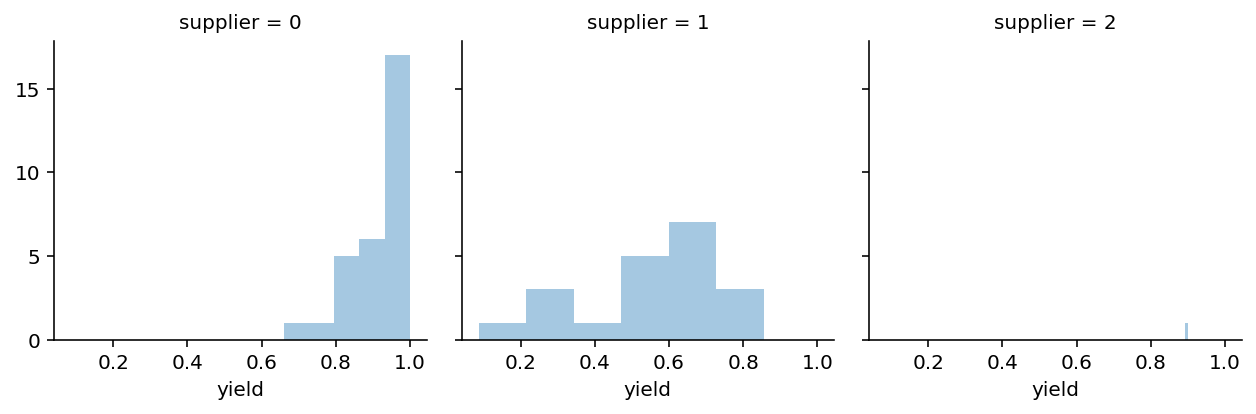

In [4]:
data_df = pd.DataFrame(data).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

## Operation system set up

The problem is summarized as how to decide the order quantity given holding cost and yield. If we buy too many, we will spend a lot in holding them in storage, and if we buy too few, we are giving up the money we could have earned.

Assume that we can sell the product at the price of 500, and the holding cost for each product is 100.

In [6]:
SALES_PRICE = 500 
HOLDING_COST = 100

Also define the **loss function**.

Input: 
- storage amount
- demand
- buy price for each product
- sell price for each product
- holding cost for each product in stock

Output:
The negative of profit

In [154]:
@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    
    # How much do we earn per launch
    margin = sales_price - buy_price
    
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin
    
    # minimize, so invert
    return -reward

**Simulate the demand**. Assume that we have been operating the business for a long time and the demand is pretty stable. We have the empirical distribution for demand.

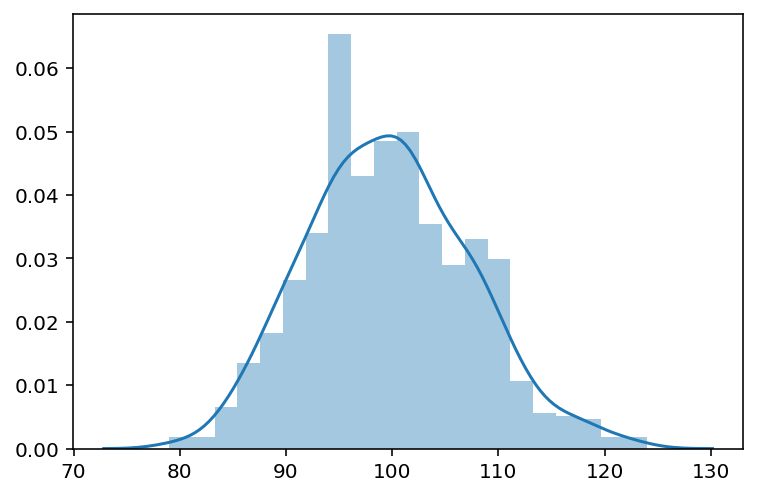

In [8]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.distplot(demand_samples)
plt.show()

Play around with profit (negative loss), demand, and storage.

1. Fix demand, the relationship between profit and stoarge

Assume demand is 50. We can see that the profit increases as the storage increases, and drops down if the storage exceeds the demand. This is because we have to pay for the holding cost if we have more than we can sell.

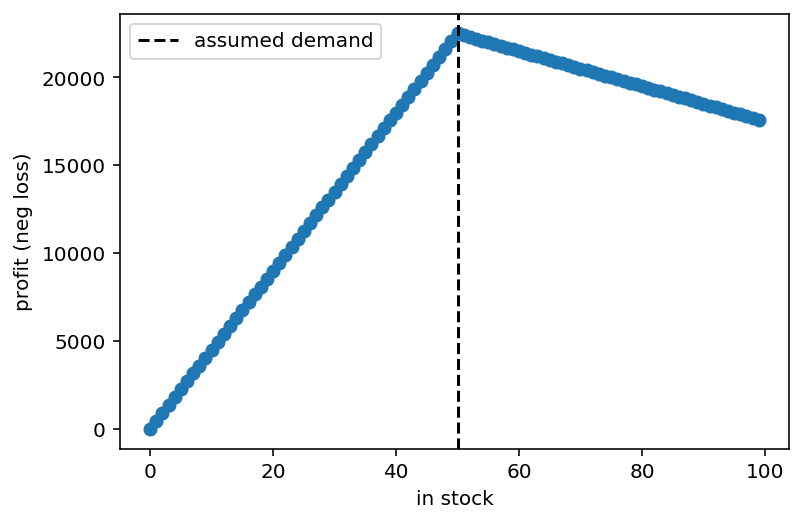

In [155]:
in_stock = np.arange(0, 100)
plt.scatter(in_stock, -loss(in_stock, demand=50, buy_price=50))
plt.axvline(50, c='k', ls='--', label='assumed demand')
plt.xlabel('in stock')
plt.ylabel('profit (neg loss)')
plt.legend()
plt.show()

2. Fix storage, the relationship between profit and demand

Assume storage amount is 100. Profit increases as demand increases. However, profit remains the same if demand exceeds storage amount. This is because we can't sell any more if we have sold out what we have in stock.

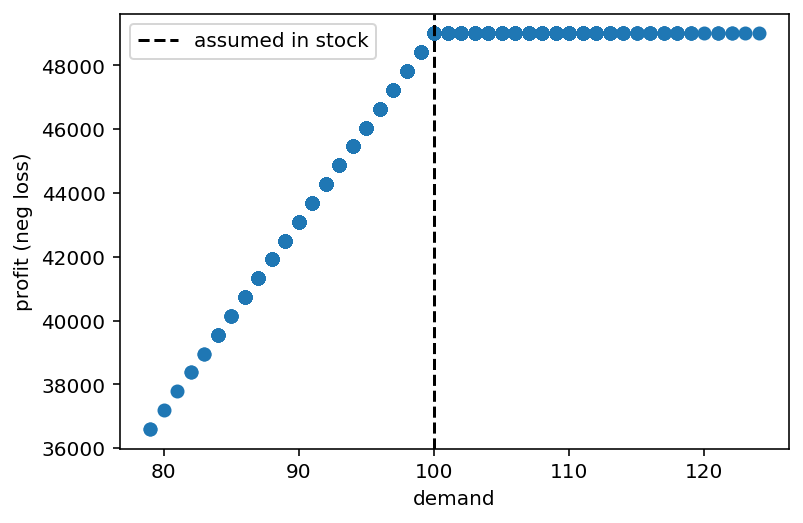

In [10]:
plt.scatter(demand_samples, -loss(in_stock=100, demand=demand_samples, buy_price=10))
plt.xlabel('demand')
plt.ylabel('profit (neg loss)')
plt.axvline(100, c='k', ls='--', label='assumed in stock')
plt.legend()
plt.show()

## Estimating yield with Bayesian hierarchical model

Rationale behind hierarchical model:
Different supplier has different production line. How they operate and supervise the production should be different as well. However, it is reasonable to suspect that the three suppliers share similarities since they are producing the same product and there should be a certain "upper bound" with regard to producing this product.


So, mathematically it is shown in the graph below:

The yield distribution for each supplier is different since they have different parameters. But the parameters themselves are from the same distribution, which provides each supplier with both individual differences and similarities.

In [11]:
supplier_idx = np.array([0]*N_OBS[0]+[1]*N_OBS[1]+[2]*N_OBS[2])

with pm.Model() as partial_pooling:
    # Hyperpriors:
    sigma_α = pm.HalfCauchy('sigma_α', beta=1)
    sigma_β = pm.HalfCauchy('sigma_β', beta=1)

    # alpha and beta for each supplier:
    alpha = pm.HalfNormal('alpha', sd=sigma_α, shape=3)
    beta = pm.HalfNormal('beta', sd=sigma_β, shape=3)
    
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}', 
            alpha=alpha[i], beta=beta[i],
            observed=d)

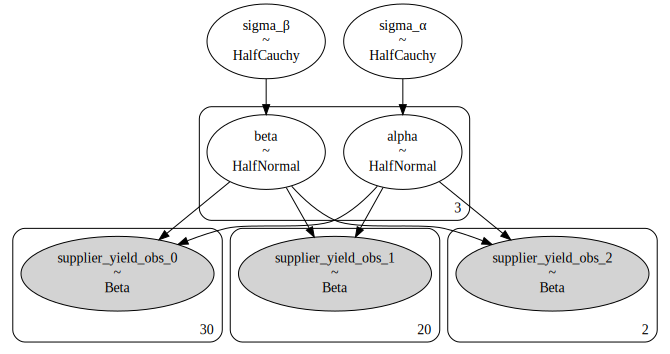

In [12]:
pm.model_to_graphviz(partial_pooling)

In [13]:
with partial_pooling:
    partial_pooling_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma_β, sigma_α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc94200d7d0>,
      dtype=object)

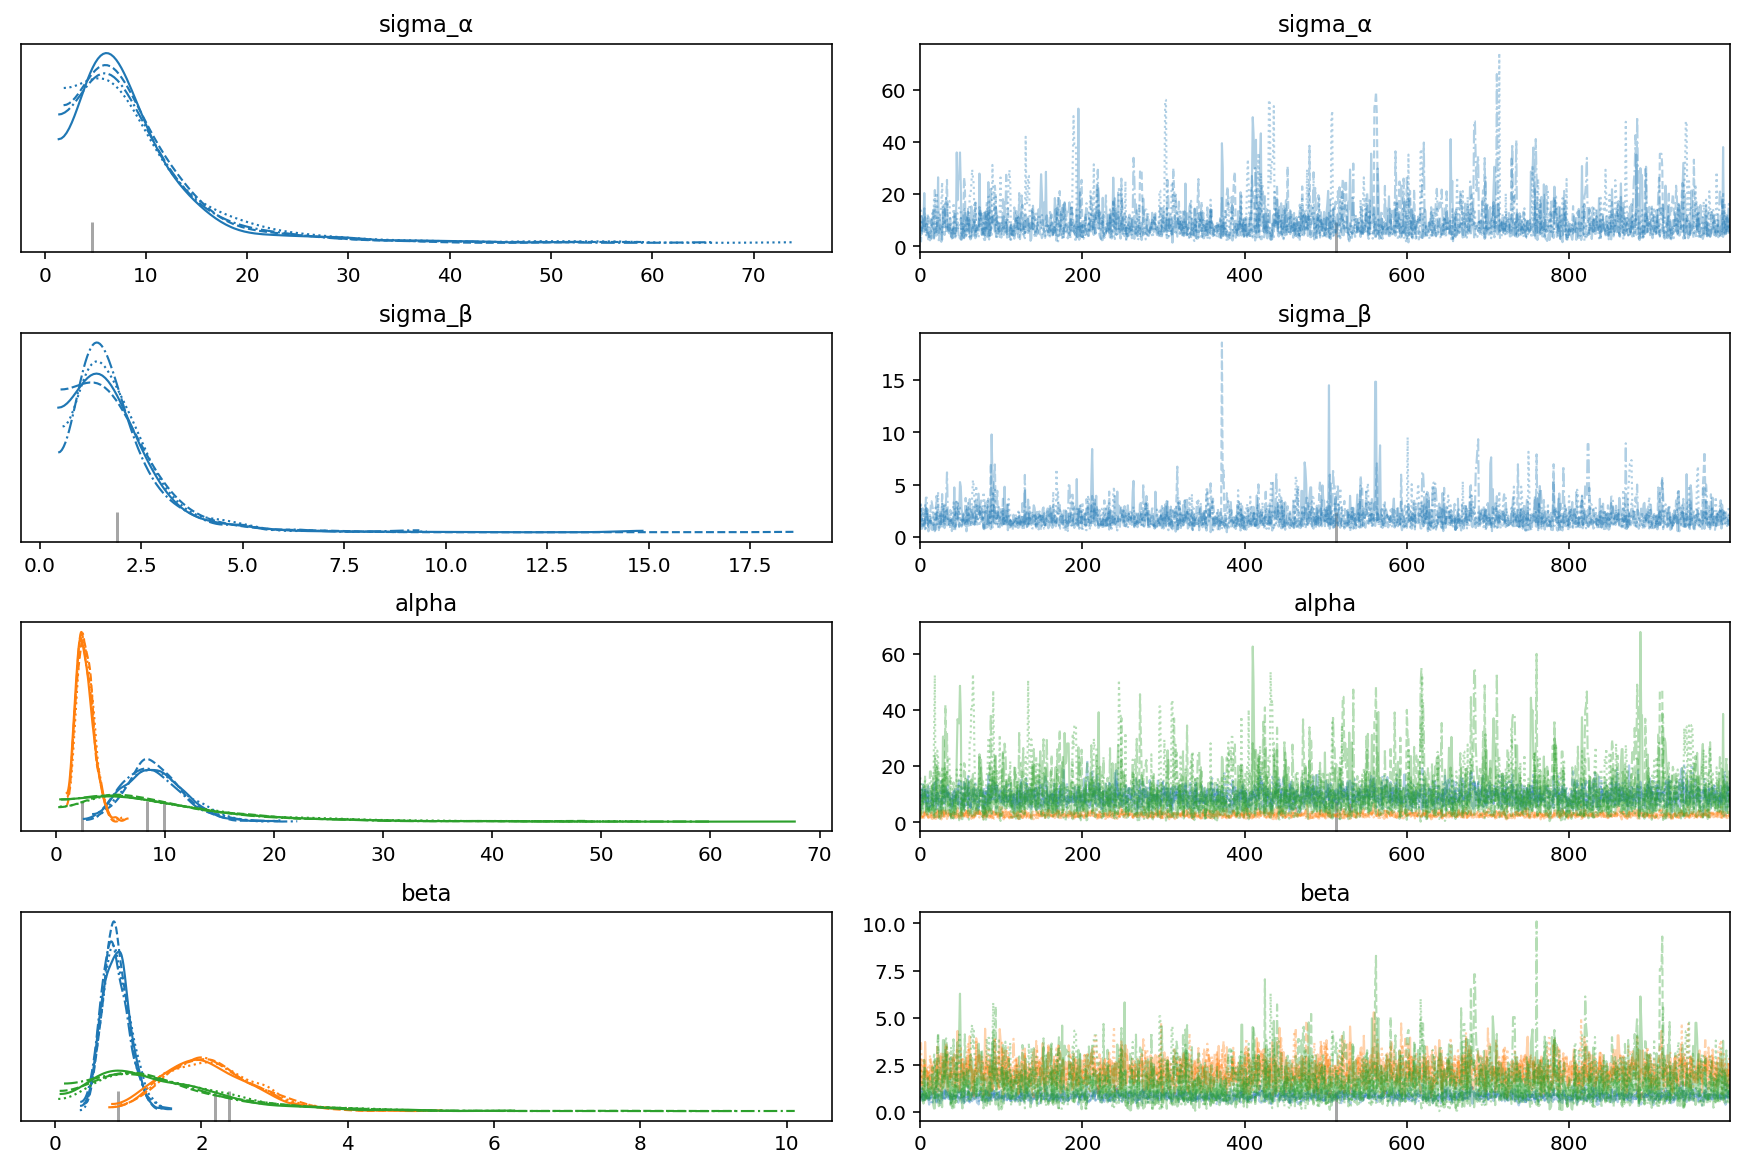

In [14]:
pm.traceplot(partial_pooling_trace)

In [15]:
pm.summary(partial_pooling_trace)

/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_α,9.304,6.769,1.872,20.716,0.173,0.122,1539.0,1539.0,1808.0,1772.0,1.0
sigma_β,1.925,1.132,0.531,3.672,0.027,0.019,1747.0,1747.0,1989.0,1834.0,1.0
alpha[0],9.149,2.683,4.471,14.253,0.061,0.043,1936.0,1936.0,1903.0,2146.0,1.0
alpha[1],2.690,0.789,1.366,4.188,0.017,0.012,2083.0,2083.0,2041.0,2548.0,1.0
alpha[2],10.252,8.165,0.545,25.006,0.211,0.149,1501.0,1501.0,1666.0,1829.0,1.0
beta[0],0.837,0.187,0.507,1.186,0.004,0.003,1889.0,1889.0,1817.0,2243.0,1.0
beta[1],2.133,0.622,0.977,3.225,0.014,0.010,2034.0,2034.0,1954.0,2863.0,1.0
beta[2],1.521,1.004,0.109,3.317,0.026,0.018,1505.0,1505.0,1510.0,1887.0,1.0


## Generate future possible scenarios

Use MCMC to sample from yield's posterior distribution.

In [16]:
with partial_pooling:
    post_pred_hie = pm.sample_posterior_predictive(partial_pooling_trace, 1000)

/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


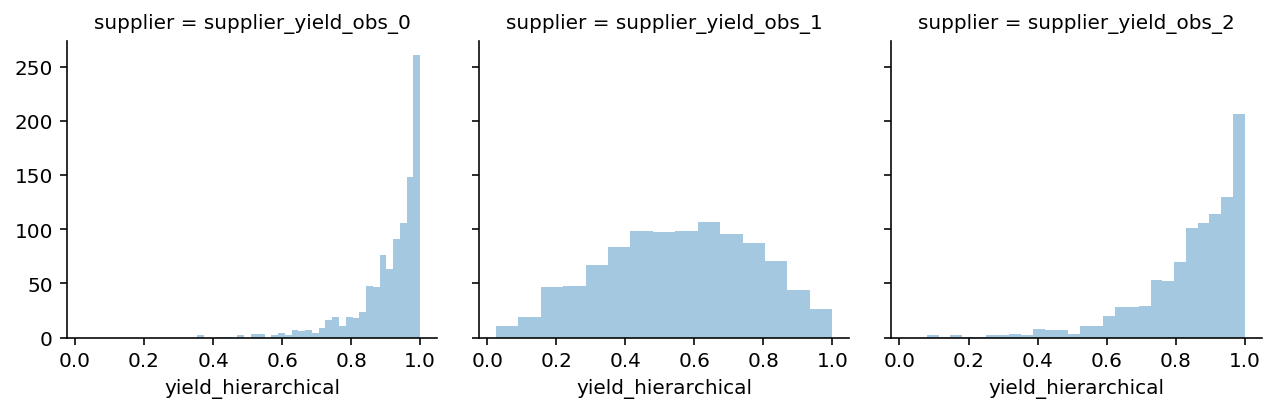

In [17]:
supplier_yield_post_pred_hie = pd.DataFrame({k: v[:, 1] for k, v in post_pred_hie.items()})
data_tidy_hie = supplier_yield_post_pred_hie.unstack().to_frame('yield_hierarchical')
data_tidy_hie.index = data_tidy_hie.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy_hie.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield_hierarchical', kde=False)
plt.show()

From the predictive posterior distribution of yield we can see that Bayesian modelling takes uncertainty into account. For supplier_2, the posterior yield has a lot of uncertainty because we only have 2 observations. For supplier_1, the historical data is wide-spread, so the sampled from posterior predictive also shows a lot of uncertainty.

Calculate full yield and effective price given the yield for each supplier and their prices.

In [18]:
def calc_yield_and_price(orders, 
                         supplier_yield=np.array([.9, .5, .8]),
                         prices=PRICES):
    orders = np.asarray(orders)
    
    full_yield = np.sum(supplier_yield * orders)
    price_per_item = np.sum(orders * prices) / np.sum(orders)
    
    return full_yield, price_per_item

calc_yield_and_price([100, 60, 60])

(168.0, 160.0)

For example, if we order from supplier 1,2,3 with the order quantities 100, 60, 60, and their yields are 0.9, 0.5, 0.8 respectively, we would have full yield 168 and the average price per item 160.

## Optimization: Find the Distribution of arg min

The objective function:

- first calculate full yield and average price per item given a posterior predictive yield sample
- using the above with demand (sample from demand samples), compute the loss

In [19]:
# for each sample drawn from the predictive posterior distribution of yield, calculate the objective function

def obj_per_sample(orders, supplier_yield_sample, demand_sample, max_order_size=MAX_ORDER_SIZE):
    
    orders = np.asarray(orders)
    
    if np.any(orders<0):
        return np.inf
    if np.any(orders>MAX_ORDER_SIZE):
        return np.inf
    
    full_yield, price_per_item = calc_yield_and_price(orders, supplier_yield=supplier_yield_sample)
    
    loss_sample = loss(full_yield, demand_sample, price_per_item)
    
    return loss_sample

In [20]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

In [21]:
noise=4
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

MAX_ORDER_SIZE = [100.0, 80.0, 100.0]
bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]

In [22]:
opt_val = []
opt_x = []

# For each sample from the posterior predictive distribution of yield estimation
# there is an objective function, given a value of demand (a random sample from Poisson distribution).

# Use BO to find the arg min of each objective function.
# We will obtain a bunch of arg mins, so that we have a distribution of the arg min
# as well as a distribution of minimum.

for i, j in supplier_yield_post_pred_hie.iterrows():
    opt_i = gp_minimize(lambda *args: np.mean(obj_per_sample(*args,
                                             supplier_yield_sample=np.array(j), 
                                             demand_sample=demand_samples[i])), 
                dimensions=bounds,
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.03,            # exploitation-exploration trade-off
                n_calls=15,         # number of iterations
                n_random_starts=1)  # initial samples are not provided
    
    opt_val.append(opt_i.fun)
    opt_x.append(opt_i.x)

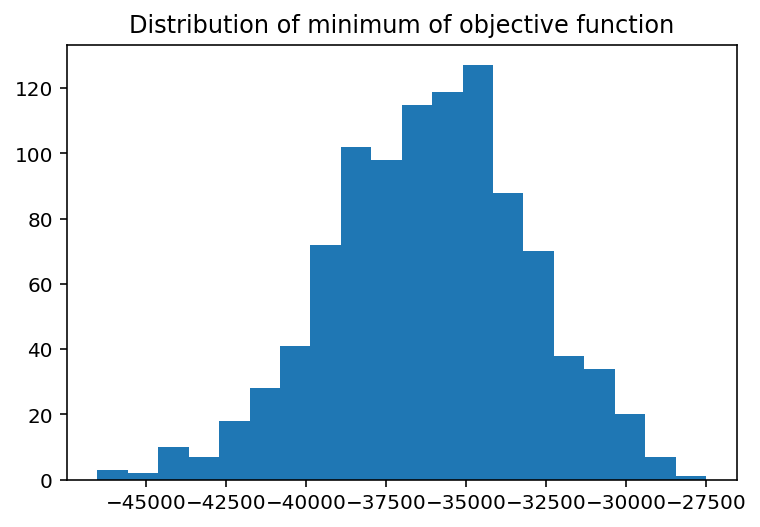

In [24]:
fig, ax = plt.subplots(1,1)
ax.hist(opt_val, bins=20)
ax.set_title('Distribution of minimum of objective function')
plt.show()

The distribution of arg min (order quantities from 3 suppliers)

In [25]:
o1 = np.transpose(opt_x)[0]
o2 = np.transpose(opt_x)[1]
o3 = np.transpose(opt_x)[2]

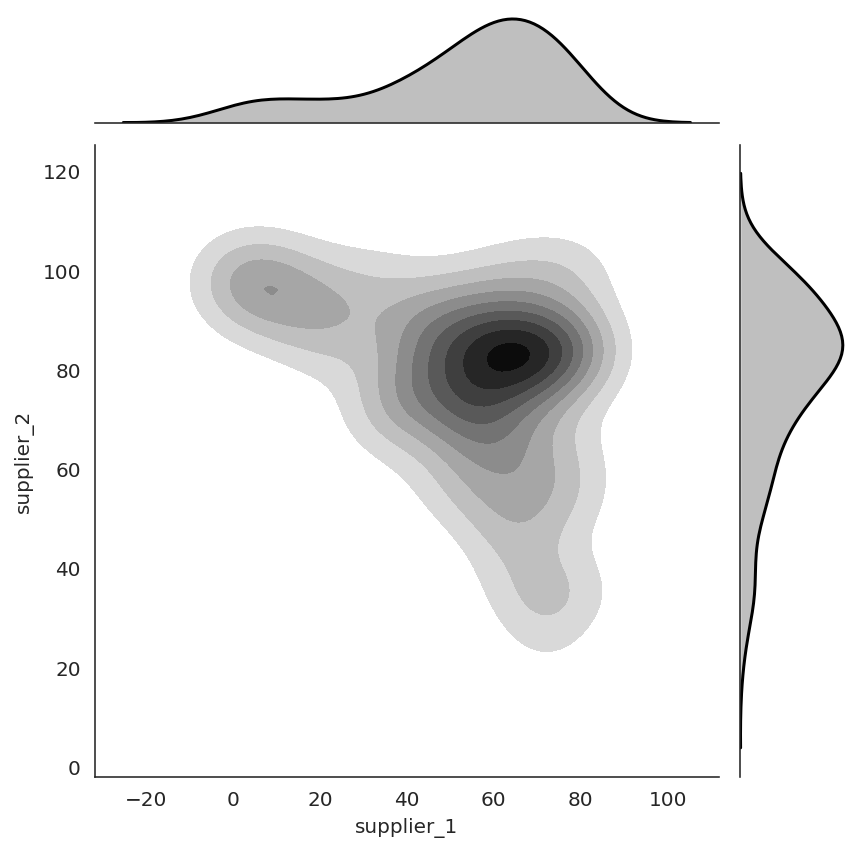

In [44]:
x2 = []
x3 = []
for i in range(999):
    if np.rint(opt_x[i][0]) == 0:
        x2.append(opt_x[i][1])
        x3.append(opt_x[i][2])

plot_data = []
for i in range(len(x2)):
    plot_data.append([x2[i],x3[i]])
plot_data = pd.DataFrame(plot_data)
plot_data.columns = ['supplier_1','supplier_2']

# Fix order quantities from supplier_0, the distribution of order quantities from the other two suppliers
with sns.axes_style("white"):
    g = sns.jointplot(x=plot_data['supplier_1'], y=plot_data['supplier_2'],data = plot_data,
                  kind="kde", color="k",shade_lowest=False)

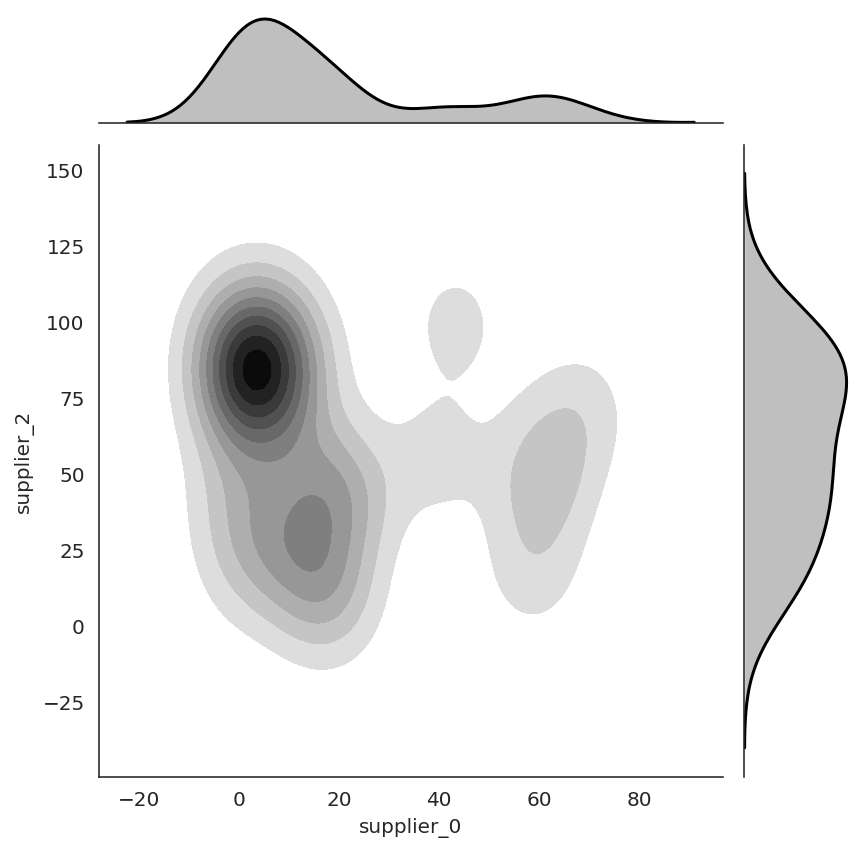

In [40]:
x1 = []
x3 = []
for i in range(999):
    if np.rint(opt_x[i][1]) == 80:
        x1.append(opt_x[i][0])
        x3.append(opt_x[i][2])

plot_data = []
for i in range(len(x1)):
    plot_data.append([x1[i],x3[i]])
plot_data = pd.DataFrame(plot_data)
plot_data.columns = ['supplier_0','supplier_2']

# Fix order quantities from supplier_1, the distribution of order quantities from the other two suppliers
with sns.axes_style("white"):
    g = sns.jointplot(x=plot_data['supplier_0'], y=plot_data['supplier_2'],data = plot_data,
                  kind="kde", color="k",shade_lowest=False)

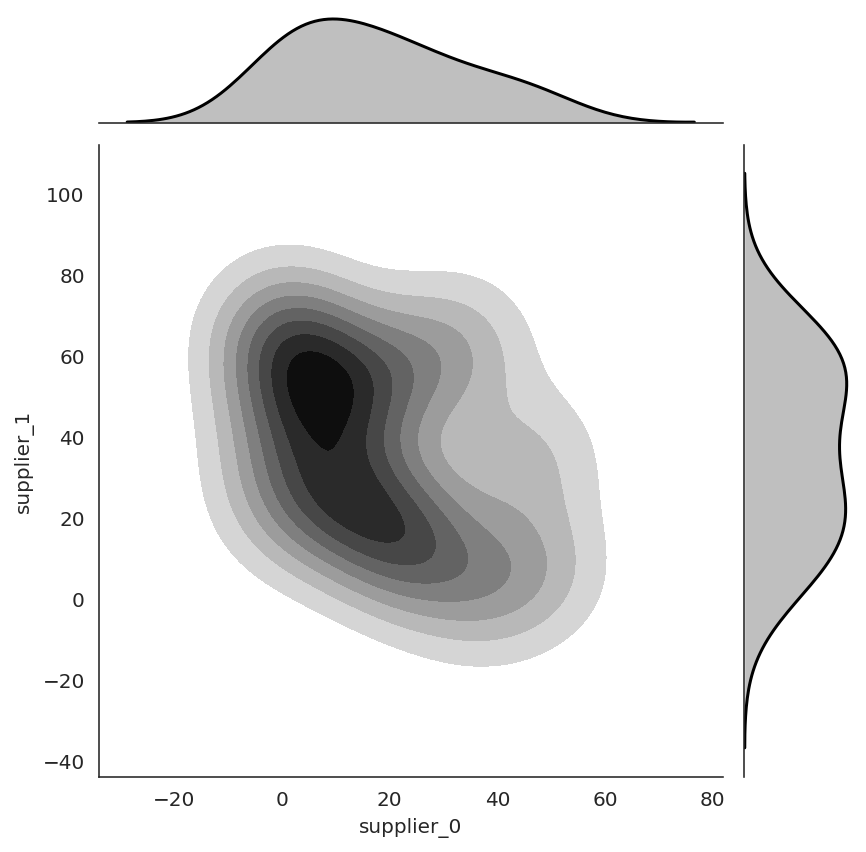

In [39]:
x1 = []
x2 = []
for i in range(999):
    if np.rint(opt_x[i][2]) == 85:
        x1.append(opt_x[i][0])
        x2.append(opt_x[i][1])
plot_data = []
for i in range(len(x1)):
    plot_data.append([x1[i],x2[i]])
plot_data = pd.DataFrame(plot_data)
plot_data.columns = ['supplier_0','supplier_1']

# Fix order quantities from supplier_2, the distribution of order quantities from the other two suppliers
with sns.axes_style("white"):
    g = sns.jointplot(x=plot_data['supplier_0'], y=plot_data['supplier_1'],data = plot_data,
                  kind="kde", color="k", shade_lowest=False)

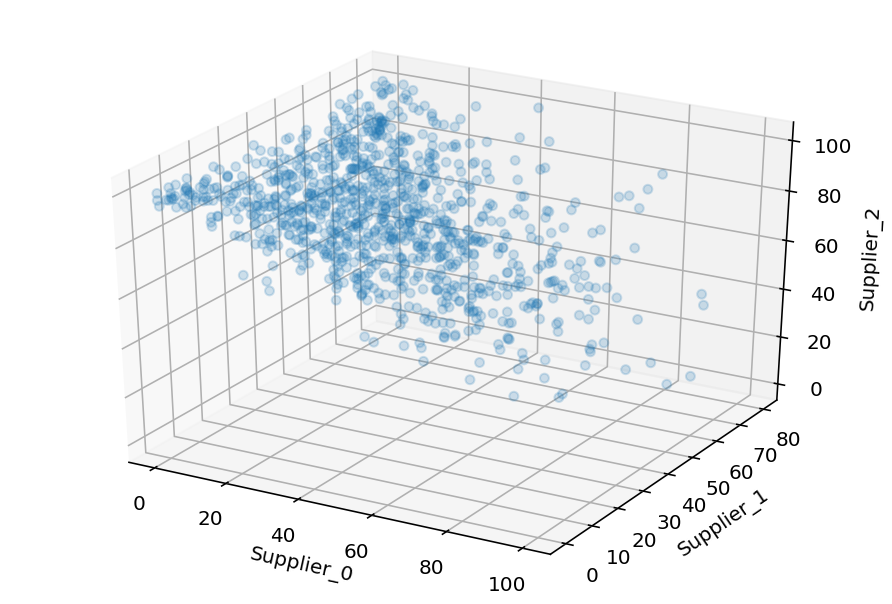

In [46]:
# 3D visualization of the arg min
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(o1, o2, o3,alpha=0.2)

ax.set_zlabel('Supplier_2')  
ax.set_ylabel('Supplier_1')
ax.set_xlabel('Supplier_0')
plt.show()

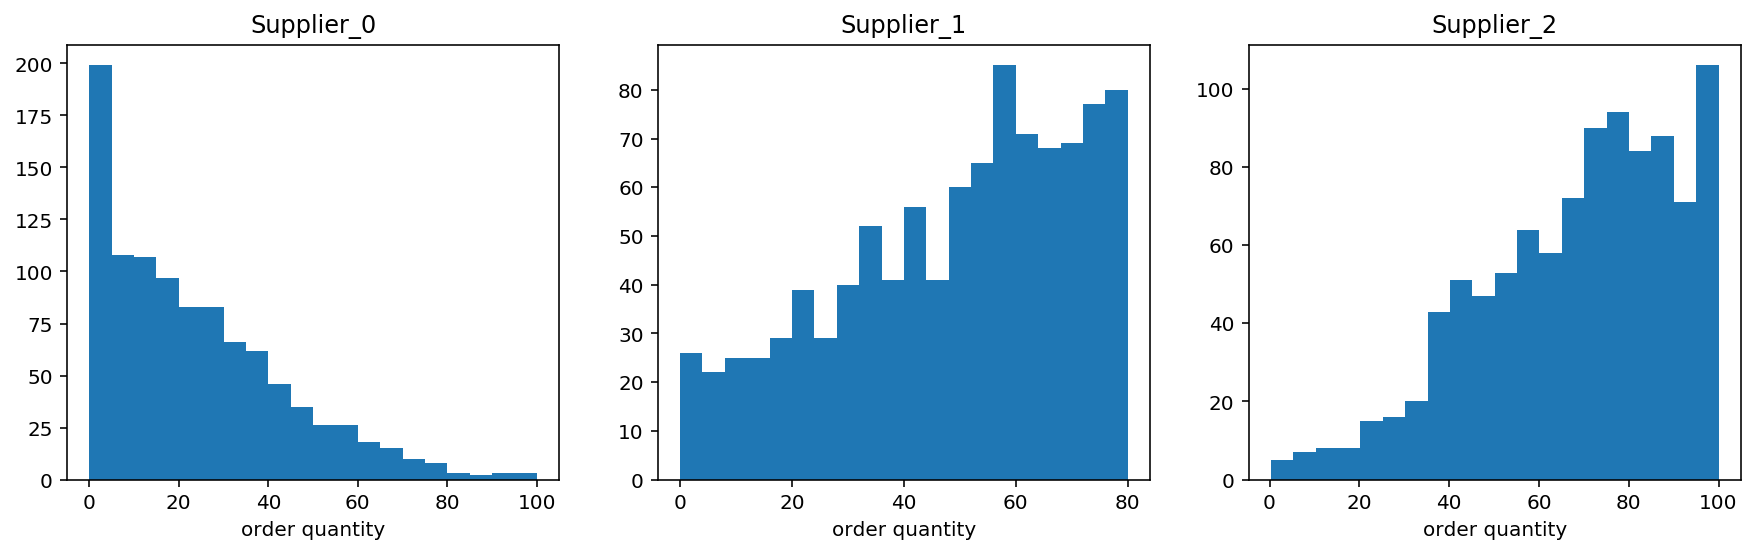

In [51]:
# marginal distribution of order quantities for each supplier
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,4))
ax1.hist(o1,bins=20)
ax1.set_title('Supplier_0')
ax1.set_xlabel('order quantity')

ax2.hist(o2,bins=20)
ax2.set_title('Supplier_1')
ax2.set_xlabel('order quantity')

ax3.hist(o3,bins=20)
ax3.set_title('Supplier_2')
ax3.set_xlabel('order quantity')
plt.show()

## Expected Profit on New Data: Comparison between Bayesian and Frequential

To obtain the expected profit, we need to first obtain a single optimal quantities from the 3 suppliers, and then compute the expected profit by plugging in new yield data. 

Bayesian framework: find the optimal order quantities by optimizing over all possible scenarios.

Frequential framework: find the optimal order quantities by optimizing over the most likely future scenario (i.e. the mean of yield from historical data).

In [58]:
# generate new yield data (from the true (unknown) distribution)
np.random.seed(123)
data_new = []
for supplier_yield, supplier_yield_sd in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD):
    data_new.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=1000).random())
data_new = pd.DataFrame(data_new).T

In [156]:
def objective(orders, supplier_yield=supplier_yield_post_pred_hie,
              demand_samples=demand_samples, max_order_size=MAX_ORDER_SIZE):
    
    orders = np.asarray(orders)
    losses = []
    
    # Negative orders are impossible, indicated by np.inf
    if np.any(orders < 0):
        return np.inf
    # Ordering more than the supplier can ship is also impossible
    if np.any(orders > MAX_ORDER_SIZE):
        return np.inf
    
    # Iterate over post pred samples provided in supplier_yield
    for i, supplier_yield_sample in supplier_yield.iterrows():
        full_yield, price_per_item = calc_yield_and_price(
            orders,
            supplier_yield=supplier_yield_sample
        )
        
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i = loss(full_yield, demand_samples[i], price_per_item)
        
        losses.append(loss_i)
        
    return np.asarray(losses)

In [145]:
noise=4
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]

r = gp_minimize(lambda *args: np.mean(objective(*args)), 
                dimensions=bounds,
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.05,            # exploitation-exploration trade-off
                n_calls=35,         # number of iterations
                n_random_starts=1)  # initial samples are not provided

In [161]:
print('The optimal order quantities under Bayesian framework is',np.rint(r.x))
print('The total order quantities under Bayesian framework is',np.rint(np.sum(r.x)))

The optimal order quantities under Bayesian framework is [ 0. 72. 87.]
The total order quantities under Bayesian framework is 159.0


In [149]:
supplier_yield_mean = pd.DataFrame([np.mean(d) for d in data]).T

r_f = gp_minimize(lambda *args: np.mean(objective(*args,
                                         supplier_yield=supplier_yield_mean,
                                         demand_samples=[100])), 
                dimensions=bounds,
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=20,         # number of iterations
                n_random_starts=1)  # initial samples are not provided

In [162]:
print('The optimal order quantities under frequential framework is',np.rint(r_f.x))
print('The total order quantities under frequential framework is',np.rint(np.sum(r_f.x)))

The optimal order quantities under frequential framework is [75. 58.  9.]
The total order quantities under frequential framework is 141.0


**Quick note**: The Bayesian method doesn't like ordering from the high-quality and high-cost supplier. And it also orders more in total so that it could compensate for the lower yield.

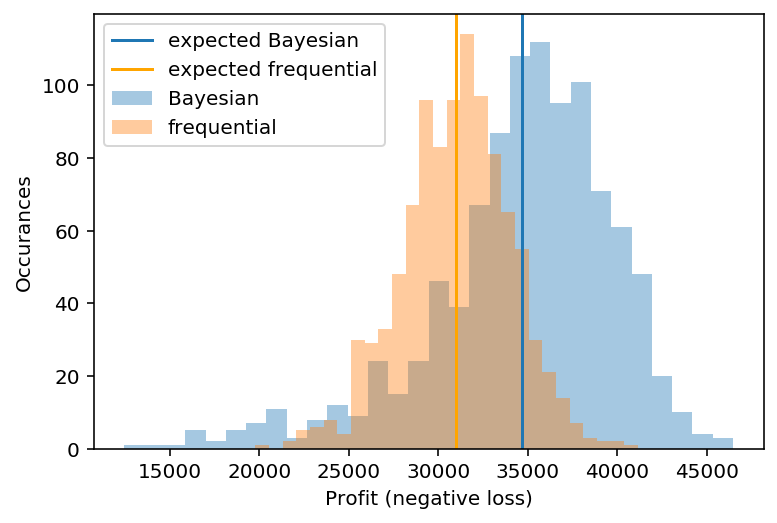

In [151]:
neg_loss_bay = -objective(r.x, supplier_yield=data_new)
neg_loss_freq = -objective(r_f.x, supplier_yield=data_new)

sns.distplot(neg_loss_bay, label='Bayesian', kde=False)
plt.axvline(np.mean(neg_loss_bay), label='expected Bayesian')

sns.distplot(neg_loss_freq, label='frequential', kde=False)
plt.axvline(np.mean(neg_loss_freq), color='orange', label='expected frequential')

plt.legend()
plt.xlabel('Profit (negative loss)')
plt.ylabel('Occurances')
plt.show()

In [166]:
print('Expected profit of Bayesian model:', round(np.mean(neg_loss_bay),2))
print('Expected profit of frequential model:', round(np.mean(neg_loss_freq),2))

Expected profit of Bayesian model: 34693.07
Expected profit of frequential model: 30995.67


The distribution of profit under Bayesian model seems to be more wide-spread. It demonstrates the Bayesian estimation of order quantities is more robust than the other estimation method. From the distribution plot we could see that if the true yield from suppliers has a drastic change (e.g. due to production machine bug) and the demand behaves normally (i.e. no external turbulence, e.g. no COVID-19 outbreak), the optimal quantities from 3 suppliers obtained from Bayesian framework could give us a "more stable" and higher profit.